In [1]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
from matplotlib import pyplot as plt

import datetime
import pickle

from linearmodels import PanelOLS

import statsmodels.api as sm

fin = open("/media/data/slavadoData/creds_mysql.txt", 'r')
creds = fin.read().split("\n")

In [2]:
import mysql.connector

mydb = mysql.connector.connect(
  host= creds[0],
  user= creds[1],
  passwd= creds[2]
)

print(mydb)

In [3]:
# get data from 2017-2020, the years of analysis 
query = "select * from d4c2020.all_ports_plus_vessels_alldates where `Data DD-MM-AAAA` >= '2017-01-01'"

df_raw = pd.read_sql(query, mydb)

In [4]:
df = df_raw.copy()
df.shape

(5023805, 17)

# DATA PREP

In [5]:
df.columns = df.columns.str.replace(' ', '_')

In [6]:
# Extract info from date of sale

df['year'] = pd.DatetimeIndex(df['Data_DD-MM-AAAA']).year
df['month'] = pd.DatetimeIndex(df['Data_DD-MM-AAAA']).month
df['day'] = pd.DatetimeIndex(df['Data_DD-MM-AAAA']).day
df['week'] = pd.DatetimeIndex(df['Data_DD-MM-AAAA']).week

In [7]:
# We want to aggregate data per year-week; however, the last days of an year may be attributed to week 1
# of the next year. Simply concatenating year-week would produce a wrong value.
# We calculate a new year to concatenate, correcting this issue.

def year4week(row):
    if (row['week'] == 1) and (row['month'] == 12):
        return row['year'] + 1
    else:
        return row['year']
    
df['year4week'] = df.apply(year4week, axis=1)

In [8]:
# Create the year_week variable, concatenating year and week strings

df['year_week'] = df['year4week'].astype(str) + df['week'].astype(str).str.pad(2, side='left', fillchar='0')
df[(df['month'] == 12) & (df['year'] == 2018)].tail()

,Data_DD-MM-AAAA,LotaCod,Nome_Lota,BarcoId,Nome_Espécie,TAM,FRESC,EspecieCod,NomeCientifico,kg,euros,prméd,CompradorId,Tipo_Comb.,CFF,Portuguese,Description,year,month,day,week,year4week,year_week
4825644,2018-12-31,20940,Vila do Conde,13949,Polvo-vulgar,NULL,NULL,OCC,Octopus vulgaris,10.00,50.00,5.00,8425,D,8.0,Yes,Gasóleo,2018,12,31,1,2019,201901
4825645,2018-12-31,20940,Vila do Conde,11296,Polvo-vulgar,NULL,NULL,OCC,Octopus vulgaris,10.00,50.00,5.00,10446,D,8.5,Yes,Gasóleo,2018,12,31,1,2019,201901
4825646,2018-12-31,20940,Vila do Conde,10687,Polvo-vulgar,NULL,NULL,OCC,Octopus vulgaris,16.00,80.00,5.00,3496,G,7.95,Yes,Gasolina,2018,12,31,1,2019,201901
4825647,2018-12-31,20940,Vila do Conde,13949,Choco-vulgar,T2,A,CTC,Sepia officinalis,2.00,8.00,4.00,8425,D,8.0,Yes,Gasóleo,2018,12,31,1,2019,201901
4825648,2018-12-31,20940,Vila do Conde,10492,Choco-vulgar,T2,A,CTC,Sepia officinalis,3.00,10.50,3.50,6377,D,8.95,Yes,Gasóleo,2018,12,31,1,2019,201901


In [9]:
# Attribute each lota to a NUT region

def nuts(val):
    
    if val in ['Albufeira', 'Lagos', 'Olhão', 'Portimão', 'Quarteira', 'Sagres', 'V.R.S. António',
              'Lagos/F Lota', 'Olhão/F Lota', 'Portimão/F Lota', 'Quarteira/F Lota', 'Sagres/F Lota', 
               'V.R.S. António/F Lota']:
        return 'Algarve'
    elif val in ['Sines', 'V.N.Milfontes', 'Sines/F Lota']:
        return 'Alentejo'
    elif val in ['Setúbal', 'Sesimbra', 'Costa da Caparica', 'Sesimbra/F Lota', 'Setúbal/F Lota']:
        return 'AML'
    elif val in ['Aveiro', 'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 
                 'Aveiro/F Lota', 'Figueira da Foz/F Lota', 'Nazaré/F Lota', 'Peniche/F Lota']:
        return 'Centro'
    elif val in ['Matosinhos', 'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo', 'Vila do Conde', 
                'Matosinhos/F Lota', 'Póvoa de Varzim/F Lota', 'Viana do Castelo/F Lota']:
        return 'Norte'

df['nuts'] =  df['Nome_Lota'].apply(nuts)

# Species selection

## Species highest economic value

In [10]:
# Get the list of species with highest economic weight, per NUT

species_economic_value = pd.read_csv('species_highest_economic_weight_region.csv')
species_economic_value = species_economic_value[['Nome Espécie', 'Região']]
species_economic_value.columns = ['species', 'nuts']
species_economic_value.head()

,species,nuts
0,Polvo-vulgar,Norte
1,Robalo-legitimo,Norte
2,Faneca,Norte
3,Linguado-legítimo,Norte
4,Pescada-branca,Norte


In [11]:
# Filter out species that are not in the list of species with highest economic weight, through an inner join

df_econ_val = df.merge(species_economic_value, left_on=['nuts', 'Nome_Espécie'], right_on=['nuts', 'species'])
df_econ_val.shape

(2692903, 25)

In [12]:
# Check everything is as expected

pd.crosstab(df_econ_val['nuts'], df_econ_val['Nome_Espécie'])

Nome_Espécie,Abrotea-da-costa,Amêijoa-japonesa,Atum-rabilho,Azevias,Bica,Carapau,Cavala,Cherne,Choco-vulgar,Congro,Corvina-legitima,Dourada,Faneca,Galo-negro,Goraz,Lampreia-do-mar,Linguado-legítimo,Ouriço-do-mar,Pargo-legitimo,Peixe-espada-preto,Perceve,Pescada-branca,Polvo-vulgar,Raia-lenga,Robalo-legitimo,Salmonete-legitimo,Sargo-legitimo,Savel,Solha-legítima,Tamboril-preto
nuts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AML,0,11310,0,0,0,0,16402,0,85909,0,49555,30749,0,0,0,0,52572,0,0,1900,0,65153,125672,58869,54489,0,0,0,0,14186
Alentejo,17616,0,0,0,0,0,0,0,8589,22707,0,7091,0,5203,0,0,0,0,5590,0,0,0,60455,0,10794,6309,10403,0,0,0
Algarve,0,0,0,57833,53012,0,0,0,96472,0,13758,51705,0,0,0,0,31812,0,23862,0,0,0,245366,0,0,34160,41085,0,0,25500
Centro,0,0,0,0,0,59638,0,11702,57343,96564,0,34351,67988,33647,14636,0,48132,0,0,0,7264,102230,103851,79713,93627,0,52327,0,0,0
Norte,0,0,26,0,0,38914,0,0,0,56650,0,0,85944,10796,0,3841,46789,6146,0,0,5409,68697,40235,0,39195,0,0,11514,19646,0


## Species with price and volume above mean

In [13]:
# Get the list of the most valued species (price and volume above mean)

species_most_valued = pd.read_csv('most_valued_species.csv')
species_most_valued = species_most_valued[['Nome Espécie', 'nuts']]
species_most_valued.columns = ['species', 'nuts']
species_most_valued.head()

,species,nuts
0,Linguado-legítimo,Norte
1,Robalo-legitimo,Norte
2,Polvo-vulgar,Norte
3,Juliana,Norte
4,Tamboril-branco,Norte


In [14]:
# Filter out species that are not in the list of most valued species, through an inner join

df_val = df.merge(species_most_valued, left_on=['nuts', 'Nome_Espécie'], right_on=['nuts', 'species'])
df_val.shape

(1965110, 25)

In [15]:
# Check everything is as expected

pd.crosstab(df_val['nuts'], df_val['Nome_Espécie'])

Nome_Espécie,Amêijoa-boa,Azevia-raiada,Azevias,Besugo,Cherne,Choco-vulgar,Corvina-legitima,Dourada,Galo-negro,Goraz,Juliana,Lingua,Linguado-da-areia,Linguado-legítimo,Pargo-legitimo,Peixe-espada-branco,Peixe-espada-preto,Perceve,Polvo-vulgar,Robalo-legitimo,Salmonete-legitimo,Sargo-legitimo,Tamboril-branco,Tamboril-preto
nuts,,,,,,,,,,,,,,,,,,,,,,,,
AML,0,0,0,17329,0,85909,49555,30749,0,0,0,0,0,52572,0,0,0,0,125672,54489,0,23492,0,14186
Alentejo,0,0,0,0,0,8589,0,7091,5203,0,0,0,8485,0,5590,0,0,0,60455,10794,6309,10403,0,5102
Algarve,8559,20127,57833,0,0,96472,13758,51705,8800,0,0,0,0,31812,23862,0,0,7039,245366,18283,34160,41085,0,25500
Centro,0,0,0,0,11702,57343,10561,34351,33647,14636,0,0,0,48132,19248,10236,0,7264,103851,93627,0,52327,13651,6856
Norte,0,0,0,0,0,0,0,0,0,0,17352,11196,0,46789,0,0,1101,5409,40235,39195,0,15758,4308,0


In [16]:
# Function to aggregate data by fishing unit and week

def data_aggregations(dataframe):
    
    # First, aggregate by fishing unit and day (a fishing unit usually makes several transactions per day)
    df_pre_agg = dataframe.groupby(by = ['nuts', 'Nome_Lota', 'BarcoId', 'Data_DD-MM-AAAA']).agg({ 
                                                          'year_week': 'max',
                                                          'day': 'min',
                                                          'month':'max',
                                                          'kg': 'sum',
                                                          'euros': 'sum',
                                                          'prméd': 'mean',
                                                          'CompradorId': 'nunique'
                                                         }).reset_index()
    
    # Then, average per week and fishing unit
    df_agg = df_pre_agg.groupby(by = ['nuts', 'Nome_Lota', 'BarcoId', 'year_week']).agg({ 
                                                          'Data_DD-MM-AAAA': 'nunique',
                                                          'day': 'min',
                                                          'month':'max',
                                                          'kg': 'mean',
                                                          'euros': 'mean',
                                                          'prméd': 'mean',
                                                          'CompradorId': 'nunique'
                                                         }).reset_index()
    

    return df_agg
    

    
# Generate three aggregated datasets, one for each species group
df_aggregated = data_aggregations(df)
df_val_aggregated = data_aggregations(df_val)
df_econ_aggregated = data_aggregations(df_econ_val)

print(df_aggregated.shape)
print(df_val_aggregated.shape)
print(df_econ_aggregated.shape)

(259568, 11)
(210137, 11)
(219816, 11)


In [17]:
# Calculate the average price/kg obtained per lota and week, and add column to dataset

def lagged_prméd(dataframe):
    df_prmed_lota = dataframe.groupby(by = ['Nome_Lota', 'year_week']).agg({ 
                                                              'prméd': 'mean'
                                                             }).reset_index()

    df_prmed_lota['year_week_plus1'] = df_prmed_lota['year_week'].astype(int) + 1
    df_prmed_lota['year_week_plus1'] = df_prmed_lota['year_week_plus1'].astype(str)
    df_prmed_lota.columns = ['Nome_Lota', 'year_week', 'lagged_prméd', 'year_week_plus1']
    
    
    dataframe_merged = dataframe.merge(df_prmed_lota[['Nome_Lota', 'lagged_prméd', 'year_week_plus1']], left_on = ['Nome_Lota', 'year_week'], right_on = ['Nome_Lota', 'year_week_plus1'])
    dataframe_merged.drop('year_week_plus1', axis=1, inplace=True)
    
    
    return dataframe_merged



df_agg = lagged_prméd(df_aggregated)
df_val_agg = lagged_prméd(df_val_aggregated)
df_econ_agg = lagged_prméd(df_econ_aggregated)

df_val_agg.head()

,nuts,Nome_Lota,BarcoId,year_week,Data_DD-MM-AAAA,day,month,kg,euros,prméd,CompradorId,lagged_prméd
0,AML,Costa da Caparica,110,202018,1,28,4,27.40,120.80,5.74,1,9.92
1,AML,Costa da Caparica,1057,202018,4,1,5,14.75,68.94,4.96,3,9.92
2,AML,Costa da Caparica,1085,202018,4,27,4,16.00,87.40,5.50,2,9.92
3,AML,Costa da Caparica,1121,202018,1,27,4,31.50,448.20,14.21,1,9.92
4,AML,Costa da Caparica,1218,202018,3,27,4,25.33,124.08,4.63,3,9.92


In [18]:
# Generate label indicating whether we are in the treatment period 

def treatment_labels(row, start_week, end_week):
    if int(row['year_week']) >= start_week and int(row['year_week']) <= end_week:
        return 1
    else:
        return 0
    

df_agg['treatm_rest_closed'] = df_agg.apply(lambda row: treatment_labels(row, 202012, 202020), axis=1)  
df_val_agg['treatm_rest_closed'] = df_val_agg.apply(lambda row: treatment_labels(row, 202012, 202020), axis=1)     
df_econ_agg['treatm_rest_closed'] = df_econ_agg.apply(lambda row: treatment_labels(row, 202012, 202020), axis=1)   


# Other treatment periods we experimented with
#df_agg['treatm_lockdown'] = df_agg.apply(lambda row: treatment_labels(row, 202012, 202018), axis=1)  
#df_agg['treatm_peak'] = df_agg.apply(lambda row: treatment_labels(row, 202012, 202025), axis=1)  
#df_agg['treatm_pandemic'] = df_agg.apply(lambda row: treatment_labels(row, 202012, 202055), axis=1)  

In [19]:
# Create flag indicating whether the seafood was delivered at Lota or F/Lota 

def flota_flag(lota):
    if 'Lota' in lota:
        return 1
    else:
        return 0


def lota_flag(lota):
    if 'Lota' in lota:
        return 0
    else:
        return 1
    
    
df_agg['flota_flag'] = df_agg['Nome_Lota'].apply(flota_flag)
df_agg['lota_flag'] = df_agg['Nome_Lota'].apply(lota_flag)

df_val_agg['flota_flag'] = df_val_agg['Nome_Lota'].apply(flota_flag)
df_val_agg['lota_flag'] = df_val_agg['Nome_Lota'].apply(lota_flag)

df_econ_agg['flota_flag'] = df_econ_agg['Nome_Lota'].apply(flota_flag)
df_econ_agg['lota_flag'] = df_econ_agg['Nome_Lota'].apply(lota_flag)

In [20]:
# Create interaction variables between the lota type and the treatment period 

def interaction_vars(row, term1, term2):
    
    return row[term1] * row[term2]


df_agg['flota_treat_rest'] = df_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'treatm_rest_closed'), axis=1)  
df_agg['lota_treat_rest'] = df_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'treatm_rest_closed'), axis=1)  

df_val_agg['flota_treat_rest'] = df_val_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'treatm_rest_closed'), axis=1)  
df_val_agg['lota_treat_rest'] = df_val_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'treatm_rest_closed'), axis=1)  

df_econ_agg['flota_treat_rest'] = df_econ_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'treatm_rest_closed'), axis=1)  
df_econ_agg['lota_treat_rest'] = df_econ_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'treatm_rest_closed'), axis=1)  


In [21]:
# Aggregate lotas within the same location (useful to later merge with weather variables)

def lota_agg(lota):
    
    lota_agg = lota.partition("/")[0]
    return lota_agg

df_agg['lota_agg'] = df_agg['Nome_Lota'].apply(lota_agg)
df_val_agg['lota_agg'] = df_val_agg['Nome_Lota'].apply(lota_agg)
df_econ_agg['lota_agg'] = df_econ_agg['Nome_Lota'].apply(lota_agg)

df_val_agg['lota_agg'].unique()

array(['Costa da Caparica', 'Sesimbra', 'Setúbal', 'Sines',
       'V.N.Milfontes', 'Albufeira', 'Lagos', 'Olhão', 'Portimão',
       'Quarteira', 'Sagres', 'V.R.S. António', 'Aveiro',
       'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 'Matosinhos',
       'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo',
       'Vila do Conde'], dtype=object)

# EXTERNAL DATA IMPORT AND MERGE

## OXFORD GOVERNMENTAL RESPONSES TO PANDEMIC DATA

In [22]:
# Read data

path='OxCGRT_latest.csv'

df_oxf = pd.read_csv(path)
df_oxf = df_oxf[df_oxf['CountryName'] == 'Portugal']
df_oxf.head()

/home/slavado/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
70844,Portugal,PRT,NaN,NaN,NAT_TOTAL,20200101,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70845,Portugal,PRT,NaN,NaN,NAT_TOTAL,20200102,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70846,Portugal,PRT,NaN,NaN,NAT_TOTAL,20200103,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70847,Portugal,PRT,NaN,NaN,NAT_TOTAL,20200104,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
70848,Portugal,PRT,NaN,NaN,NAT_TOTAL,20200105,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:
# Extract info from date

df_oxf = df_oxf[['Date', 'StringencyIndex']]
df_oxf[['Date']] = df_oxf[['Date']].astype(str)
df_oxf['year'] = df_oxf['Date'].str[:4]
df_oxf['month'] = df_oxf['Date'].str[4:6]
df_oxf['day'] = df_oxf['Date'].str[6:]
df_oxf['week'] = pd.DatetimeIndex(df_oxf['Date']).week


# Create year_week variable
df_oxf['year4week'] = df_oxf.apply(year4week, axis=1)
df_oxf['year_week'] = df_oxf['year4week'] + df_oxf['week'].astype(str).str.pad(2, side='left', fillchar='0')

In [24]:
# Aggregate by week

df_oxf_week = df_oxf.groupby(by = ['year_week']).agg({ 
                                                    'Date': 'max',
                                                    'day': 'max',
                                                    'month':'max',
                                                    'StringencyIndex': 'mean',
                                                    }).reset_index()


df_oxf_week.head()

,year_week,Date,day,month,StringencyIndex
0,202001,20200105,05,01,0.00
1,202002,20200112,12,01,0.00
2,202003,20200119,19,01,0.00
3,202004,20200126,26,01,1.59
4,202005,20200202,31,02,11.11


In [25]:
# Merge with the main datasets

df_agg = pd.merge(df_agg, df_oxf_week[['year_week', 'StringencyIndex']], how='left', left_on=['year_week'], right_on=['year_week'])
df_val_agg = pd.merge(df_val_agg, df_oxf_week[['year_week', 'StringencyIndex']], how='left', left_on=['year_week'], right_on=['year_week'])
df_econ_agg = pd.merge(df_econ_agg, df_oxf_week[['year_week', 'StringencyIndex']], how='left', left_on=['year_week'], right_on=['year_week'])

In [26]:
# Fill missing with 0 (periods outside the pandemic period)

df_agg['StringencyIndex'].fillna(0, inplace = True)
df_val_agg['StringencyIndex'].fillna(0, inplace = True)
df_econ_agg['StringencyIndex'].fillna(0, inplace = True)


# Create interaction variable between the treatment variable and the type of lota

df_agg['flota_x_stringency'] = df_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'StringencyIndex'), axis=1) 
df_agg['lota_x_stringency'] = df_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'StringencyIndex'), axis=1) 


df_val_agg['flota_x_stringency'] = df_val_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'StringencyIndex'), axis=1) 
df_val_agg['lota_x_stringency'] = df_val_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'StringencyIndex'), axis=1) 


df_econ_agg['flota_x_stringency'] = df_econ_agg.apply(lambda row: interaction_vars(row, 'flota_flag', 'StringencyIndex'), axis=1) 
df_econ_agg['lota_x_stringency'] = df_econ_agg.apply(lambda row: interaction_vars(row, 'lota_flag', 'StringencyIndex'), axis=1) 

## NUMBER OF STAYS IN HOSPITALITY 

In [27]:
# Read data
path='ine_stays_revune_hospitality_interpol.csv'
df_stays = pd.read_csv(path, sep = ',')
df_stays.columns = ['index', 'date', 'year', 'nuts', 'stays', 'interp_stays', 'rev', 'interp_rev']
df_stays.head()

,index,date,year,nuts,stays,interp_stays,rev,interp_rev
0,0,2017-01-31,2017,Continente,"2,112,718.00","2,112,718.00","106,197.00","106,197.00"
1,1,2017-02-01,2017,Continente,nan,"2,126,157.14",nan,"106,684.32"
2,2,2017-02-02,2017,Continente,nan,"2,139,596.29",nan,"107,171.64"
3,3,2017-02-03,2017,Continente,nan,"2,153,035.43",nan,"107,658.96"
4,4,2017-02-04,2017,Continente,nan,"2,166,474.57",nan,"108,146.29"


In [28]:
# Extract info from date

df_stays['week'] = pd.DatetimeIndex(df_stays['date']).week
df_stays['month'] = pd.DatetimeIndex(df_stays['date']).month

# Create year_week variable
df_stays['year4week'] = df_stays.apply(year4week, axis=1)
df_stays['year_week'] = df_stays['year4week'].astype(str) + df_stays['week'].astype(str).str.pad(2, side='left', fillchar='0')


In [29]:
# Group by year_week and nuts, keeping only the last row per week and nuts
# (because data was interpolated by day, but we want interpolation by week)

df_stays_agg = df_stays.groupby(['year_week', 'nuts']).tail(1).copy()
df_stays_agg.head()

,index,date,year,nuts,stays,interp_stays,rev,interp_rev,week,month,year4week,year_week
5,5,2017-02-05,2017,Continente,nan,"2,179,913.71",nan,"108,633.61",5,2,2017,201705
12,12,2017-02-12,2017,Continente,nan,"2,273,987.71",nan,"112,044.86",6,2,2017,201706
19,19,2017-02-19,2017,Continente,nan,"2,368,061.71",nan,"115,456.11",7,2,2017,201707
26,26,2017-02-26,2017,Continente,nan,"2,462,135.71",nan,"118,867.36",8,2,2017,201708
33,33,2017-03-05,2017,Continente,nan,"2,617,052.55",nan,"127,019.74",9,3,2017,201709


In [30]:
# Merge with main dataset

df_merged = pd.merge(df_agg, df_stays_agg[['nuts', 'year_week', 'interp_stays', 'interp_rev']], how='left', left_on=['year_week', 'nuts'], right_on=['year_week', 'nuts'])

df_val_merged = pd.merge(df_val_agg, df_stays_agg[['nuts', 'year_week', 'interp_stays', 'interp_rev']], how='left', left_on=['year_week', 'nuts'], right_on=['year_week', 'nuts'])

df_econ_merged = pd.merge(df_econ_agg, df_stays_agg[['nuts', 'year_week', 'interp_stays', 'interp_rev']], how='left', left_on=['year_week', 'nuts'], right_on=['year_week', 'nuts'])

In [31]:
# Since the two variables from this dataset are highly correlated, we end up using just one (interp_stays)

df_merged[['interp_stays', 'interp_rev']].corr()

,interp_stays,interp_rev
interp_stays,1.00,0.97
interp_rev,0.97,1.00


## BUSINESS VOLUME

In [32]:
# Get data
path='ine_hospitality_business_volume_interpol.csv'
df_vol = pd.read_csv(path, sep = ',')

In [33]:
# Extract info from date

df_vol['week'] = pd.DatetimeIndex(df_vol['index']).week


# Create year_week variable
df_vol['year4week'] = df_vol.apply(year4week, axis=1)
df_vol['year_week'] = df_vol['year4week'].astype(str) + df_vol['week'].astype(str).str.pad(2, side='left', fillchar='0')


# Aggregate by week, keeping only the last row per week
# (because data was interpolated by day, but we want interpolation by week)
df_vol_agg = df_vol.groupby(['year_week']).tail(1)
df_vol_agg.head()

,Unnamed: 0,index,year,month,"Alojamento, restauracao e similares",Alojamento,Restauracao,interpolated_host,interpolated_rest,interpolated_host_rest,week,year4week,year_week
0,0,2010-01-31,2010,1.00,-1.70,-9.90,0.50,-9.90,0.50,-1.70,4,2010,201004
7,7,2010-02-07,2010,nan,nan,nan,nan,-9.62,0.50,-1.62,5,2010,201005
14,14,2010-02-14,2010,nan,nan,nan,nan,-9.35,0.50,-1.55,6,2010,201006
21,21,2010-02-21,2010,nan,nan,nan,nan,-9.07,0.50,-1.48,7,2010,201007
28,28,2010-02-28,2010,2.00,-1.40,-8.80,0.50,-8.80,0.50,-1.40,8,2010,201008


In [34]:
# Merge with the main datasets

df_external = pd.merge(df_merged, df_vol_agg[['year_week', 'interpolated_host', 'interpolated_rest', 'interpolated_host_rest']], 
                     how='left', left_on=['year_week'], right_on=['year_week'])

df_val_external = pd.merge(df_val_merged, df_vol_agg[['year_week', 'interpolated_host', 'interpolated_rest', 'interpolated_host_rest']], 
                     how='left', left_on=['year_week'], right_on=['year_week'])

df_econ_external = pd.merge(df_econ_merged, df_vol_agg[['year_week', 'interpolated_host', 'interpolated_rest', 'interpolated_host_rest']], 
                     how='left', left_on=['year_week'], right_on=['year_week'])

In [35]:
# Since the variables are highly correlated, we end up using just one (interpolated_rest)
df_external[['treatm_rest_closed', 'interp_stays', 'interp_rev', 'interpolated_host', 'interpolated_rest', 'interpolated_host_rest', 'StringencyIndex']].corr()

,treatm_rest_closed,interp_stays,interp_rev,interpolated_host,interpolated_rest,interpolated_host_rest,StringencyIndex
treatm_rest_closed,1.00,-0.24,-0.22,-0.06,-0.10,-0.09,0.50
interp_stays,-0.24,1.00,0.97,0.33,0.35,0.34,-0.45
interp_rev,-0.22,0.97,1.00,0.27,0.29,0.29,-0.39
interpolated_host,-0.06,0.33,0.27,1.00,0.99,1.00,-0.82
interpolated_rest,-0.10,0.35,0.29,0.99,1.00,1.00,-0.84
interpolated_host_rest,-0.09,0.34,0.29,1.00,1.00,1.00,-0.84
StringencyIndex,0.50,-0.45,-0.39,-0.82,-0.84,-0.84,1.00


## SEA CONDITIONS

In [36]:
# Get date
sea_conditions_df = pd.read_csv('/media/data/slavadoData/sea_conditions_20172020.csv')

sea_conditions_df.columns = ['index', 'nuts', 'lota_agg', 'year_week', 'swh', 'sst', 'mwd',
       'mwp', 'wind', 'dwi']
sea_conditions_df.head()

,index,nuts,lota_agg,year_week,swh,sst,mwd,mwp,wind,dwi
0,0,AML,Costa da Caparica,201701,1.90,15.91,251.21,9.34,5.72,104.70
1,1,AML,Sesimbra,201701,1.79,16.28,250.29,9.10,6.08,107.15
2,2,AML,Setúbal,201701,1.83,16.46,255.93,9.45,5.69,111.75
3,3,AML,Costa da Caparica,201702,2.05,15.97,325.10,10.13,6.65,154.98
4,4,AML,Sesimbra,201702,1.56,16.35,320.15,9.27,6.63,141.28


In [37]:
# Drop unwanted column 
sea_conditions_df.drop('index', axis=1, inplace=True)

In [38]:
# Cast year_week to string, for merging with main datasets
sea_conditions_df['year_week']= sea_conditions_df['year_week'].astype(str) 

In [39]:
# Merge with main datasets

df_final = pd.merge(df_external, sea_conditions_df, 
                     how='left', left_on=['year_week', 'lota_agg', 'nuts'], right_on=['year_week', 'lota_agg', 'nuts'])

df_val_final = pd.merge(df_val_external, sea_conditions_df, 
                     how='left', left_on=['year_week', 'lota_agg', 'nuts'], right_on=['year_week', 'lota_agg', 'nuts'])

df_econ_final = pd.merge(df_econ_external, sea_conditions_df, 
                     how='left', left_on=['year_week', 'lota_agg', 'nuts'], right_on=['year_week', 'lota_agg', 'nuts'])

## Descriptive analysis per boat unit and year

In [40]:
# Change the dataframe name to produce tables for different species groups
# df_final = all species
# df_val = most valued species
# df_econ = species with highest economic value

df_boat = df_final[df_final['year_week'].astype(int) >= 201705].groupby(by = ['nuts', 'lota_flag', 'BarcoId']).agg({ 
                                                          'year_week': 'nunique',
                                                          'Data_DD-MM-AAAA': 'mean', 
                                                          'kg': 'mean',
                                                          'euros': 'mean',
                                                          'prméd': 'mean'
                                                         }).reset_index()


In [41]:
df_boat.describe()

,lota_flag,BarcoId,year_week,Data_DD-MM-AAAA,kg,euros,prméd
count,"3,804.00","3,804.00","3,804.00","3,804.00","3,804.00","3,804.00","3,804.00"
mean,0.80,"9,740.22",64.44,2.00,143.72,618.76,7.60
std,0.40,"4,921.36",58.85,0.74,445.41,"2,162.45",4.97
min,0.00,90.00,1.00,1.00,1.50,1.56,0.05
25%,1.00,"5,561.75",11.00,1.41,23.77,143.23,4.84
50%,1.00,"11,304.50",45.00,1.93,48.90,264.77,7.03
75%,1.00,"14,059.50",112.00,2.49,109.23,529.78,9.05
max,1.00,"16,005.00",202.00,6.10,"9,315.50","75,817.75",110.00


In [42]:
df_boat.groupby('nuts').max()

,lota_flag,BarcoId,year_week,Data_DD-MM-AAAA,kg,euros,prméd
nuts,,,,,,,
AML,1,16004,202,4.68,"8,746.50","75,817.75",26.41
Alentejo,1,15875,183,3.82,446.20,"2,846.00",36.80
Algarve,1,16002,200,6.10,"1,884.00","9,030.42",110.00
Centro,1,16005,189,5.00,"5,006.60","45,388.01",45.21
Norte,1,15980,188,4.97,"9,315.50","49,493.97",25.71


Text(0, 0.5, 'volume médio diário')

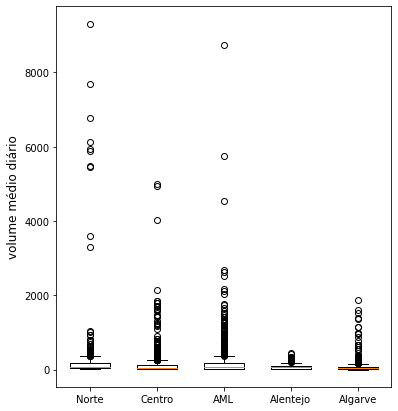

In [43]:

fig, ax = plt.subplots(figsize=(6, 7))

bp = plt.boxplot(df_boat[(df_boat['nuts'] == 'Norte')]['kg'], positions = [1], widths = 0.6, showfliers=True)
bp = plt.boxplot(df_boat[(df_boat['nuts'] == 'Centro')]['kg'], positions = [2], widths = 0.6, showfliers=True)
bp = plt.boxplot(df_boat[(df_boat['nuts'] == 'AML')]['kg'], positions = [3], widths = 0.6, showfliers=True)
bp = plt.boxplot(df_boat[(df_boat['nuts'] == 'Alentejo')]['kg'], positions = [4], widths = 0.6, showfliers=True)
bp = plt.boxplot(df_boat[(df_boat['nuts'] == 'Algarve')]['kg'], positions = [5], widths = 0.6, showfliers=True)

ax.set_xticklabels(['Norte', 'Centro', 'AML', 'Alentejo', 'Algarve'])
plt.ylabel('volume médio diário', fontsize = 12)

In [44]:
df_unique_boats = df_final[df_final['year_week'].astype(int) >= 201705].groupby(by = ['nuts', 'lota_flag']).agg({ 
                                                          'BarcoId': 'nunique'
                                                         }).reset_index()

df_unique_boats

,nuts,lota_flag,BarcoId
0,AML,0,244
1,AML,1,763
2,Alentejo,0,27
3,Alentejo,1,138
4,Algarve,0,271
5,Algarve,1,836
6,Centro,0,144
7,Centro,1,857
8,Norte,0,58
9,Norte,1,466


## Descriptive analysis per lota type, region and year 

In [45]:
df_final['year'] = df_final['year_week'].str[0:4]

df_boat_year = df_final[df_final['year_week'].astype(int) >= 201705].groupby(by = ['nuts', 'lota_flag', 'BarcoId', 'year']).agg({ 
                                                          'year_week': 'nunique',
                                                          'Data_DD-MM-AAAA': 'mean', 
                                                          'kg': 'mean',
                                                          'euros': 'mean',
                                                          'prméd': 'mean'
                                                         }).reset_index()

df_boat_year = df_boat_year.groupby(by = ['nuts', 'lota_flag', 'year']).agg({ 
                                         'BarcoId': 'nunique',
                                         'year_week': 'mean',
                                         'Data_DD-MM-AAAA': 'mean', 
                                         'kg': 'mean',
                                         'euros': 'mean',
                                         'prméd': 'mean'
                                                         }).reset_index()

df_boat_year['pct_change_up'] = df_boat_year.groupby(['nuts', 'lota_flag'])['BarcoId'].pct_change()
df_boat_year['pct_change_days'] = df_boat_year.groupby(['nuts', 'lota_flag'])['Data_DD-MM-AAAA'].pct_change()
df_boat_year['pct_change_kgs'] = df_boat_year.groupby(['nuts', 'lota_flag'])['kg'].pct_change()
df_boat_year['pct_change_prméd'] = df_boat_year.groupby(['nuts', 'lota_flag'])['prméd'].pct_change()
df_boat_year['pct_change_euros'] = df_boat_year.groupby(['nuts', 'lota_flag'])['euros'].pct_change()
df_boat_year[df_boat_year['nuts'] == 'Algarve']

,nuts,lota_flag,year,BarcoId,year_week,Data_DD-MM-AAAA,kg,euros,prméd,pct_change_up,pct_change_days,pct_change_kgs,pct_change_prméd,pct_change_euros
16,Algarve,0,2017,195,15.53,1.87,53.70,259.74,9.52,nan,nan,nan,nan,nan
17,Algarve,0,2018,192,16.93,1.85,39.40,341.12,10.29,-0.02,-0.01,-0.27,0.08,0.31
18,Algarve,0,2019,211,17.81,2.06,83.44,326.51,9.31,0.10,0.11,1.12,-0.10,-0.04
19,Algarve,0,2020,229,18.00,2.29,101.33,351.06,8.15,0.09,0.11,0.21,-0.12,0.08
20,Algarve,1,2017,681,24.26,1.95,74.46,472.71,8.41,nan,nan,nan,nan,nan
21,Algarve,1,2018,669,25.93,2.10,59.23,412.41,8.89,-0.02,0.08,-0.20,0.06,-0.13
22,Algarve,1,2019,671,27.18,2.10,75.10,461.34,8.31,0.00,-0.00,0.27,-0.07,0.12
23,Algarve,1,2020,670,28.19,2.12,75.82,460.53,8.02,-0.00,0.01,0.01,-0.04,-0.00


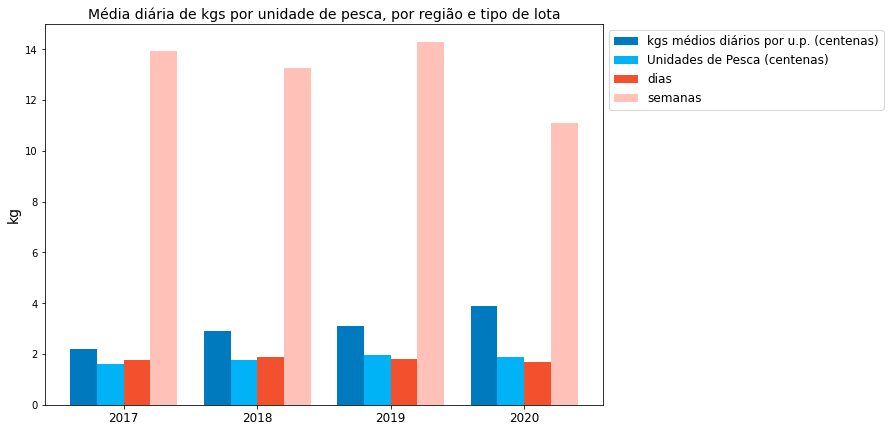

In [46]:
labels = list(df_boat_year['year'].unique())

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - (width*1.5), df_boat_year[(df_boat_year['lota_flag'] == 0) & (df_boat_year['nuts'] == 'AML')]['kg']/100, width, label='kgs médios diários por u.p. (centenas)', color = '#007abf')
rects2 = ax.bar(x - (width/2), df_boat_year[(df_boat_year['lota_flag'] == 0) & (df_boat_year['nuts'] == 'AML')]['BarcoId']/100, width, label='Unidades de Pesca (centenas)', color = '#00b3f6')
rects2 = ax.bar(x + (width/2), df_boat_year[(df_boat_year['lota_flag'] == 0) & (df_boat_year['nuts'] == 'AML')]['Data_DD-MM-AAAA'], width, label='dias', color = '#f3512e')
rects2 = ax.bar(x + (width*1.5), df_boat_year[(df_boat_year['lota_flag'] == 0) & (df_boat_year['nuts'] == 'AML')]['year_week'], width, label='semanas', color = '#ffc1b8')


['#007abf', '#00b3f6', '#99daff','#f9d979', '#f3512e', '#ffc1b8']

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('kg', fontsize=14)
ax.set_title('Média diária de kgs por unidade de pesca, por região e tipo de lota', fontsize=14)
plt.xticks(x, labels, fontsize=12)
#ax.set_xticklabels(labels, fontsize=14)
#ax.legend()

plt.legend(fontsize = 12, bbox_to_anchor=(1, 1))

plt.xticks()

#fig.tight_layout()

plt.show()

## Descriptive analysis per week, nuts and lota flag, for the period of restaurants' closure

In [47]:
# Change the dataframe name to produce tables for different species groups
# df_final = all species
# df_val_final = most valued species
# df_econ_final = species with highest economic value

df_period = df_econ_final[df_econ_final['treatm_rest_closed'] == 1].groupby(by = ['year_week','nuts', 'lota_flag']).agg({ 
                                                          'BarcoId': 'nunique',
                                                          'Data_DD-MM-AAAA': 'mean', 
                                                          'kg': 'mean',
                                                          'euros': 'mean',
                                                          'prméd': 'mean',
                                                         }).reset_index()

df_period[df_period['nuts'] == 'AML']

,year_week,nuts,lota_flag,BarcoId,Data_DD-MM-AAAA,kg,euros,prméd
0,202012,AML,0,1,1.00,398.00,649.60,1.63
1,202012,AML,1,223,2.42,45.61,288.35,7.30
9,202013,AML,1,257,2.58,68.98,249.66,6.25
17,202014,AML,0,12,1.42,356.56,586.26,2.25
18,202014,AML,1,261,2.71,65.05,289.35,6.87
26,202015,AML,0,9,1.89,436.51,687.07,2.43
27,202015,AML,1,241,2.16,69.70,412.00,7.95
35,202016,AML,0,6,2.00,318.11,383.36,1.48
36,202016,AML,1,264,1.96,57.88,339.53,7.01
44,202017,AML,0,13,2.38,471.85,583.67,2.07


In [48]:
df_period_avg = df_period.groupby(by = ['nuts', 'lota_flag']).agg({ 
                                                          'year_week': 'count',
                                                          'BarcoId': 'mean',
                                                          'Data_DD-MM-AAAA': 'mean', 
                                                          'kg': 'mean',
                                                          'euros': 'mean',
                                                          'prméd': 'mean',
                                                         }).reset_index()

df_period_avg#[df_period_avg['nuts'] == 'AML']




,nuts,lota_flag,year_week,BarcoId,Data_DD-MM-AAAA,kg,euros,prméd
0,AML,0,8,10.50,1.75,373.39,501.61,2.16
1,AML,1,9,267.00,2.44,66.09,327.30,6.93
2,Alentejo,0,1,1.00,1.00,5.00,25.00,5.00
3,Alentejo,1,9,48.00,2.08,59.52,322.37,6.60
4,Algarve,0,9,3.11,2.51,10.68,95.32,9.13
5,Algarve,1,9,319.78,2.03,61.92,355.16,6.97
6,Centro,0,9,7.67,1.27,16.47,203.88,13.83
7,Centro,1,9,255.11,2.47,82.45,464.90,7.30
8,Norte,0,9,18.89,3.08,84.56,245.02,3.64
9,Norte,1,9,102.56,2.56,60.74,242.16,5.28


## Tranformations for unit root testing

#### Get timeseries for each boat
#### Then, unit root testing was done in R

In [49]:
# Remove boats with very short timeseries

remove_boats = df_boat[df_boat['year_week'] < 7].BarcoId.unique()
df_sel_years = df_final[~df_final['BarcoId'].isin(remove_boats)]

print(df_sel_years.shape)

(235667, 33)


In [50]:
# Separate per region

df_sel_algarve = df_sel_years[df_sel_years['nuts'] == 'Algarve']
df_sel_alentejo = df_sel_years[df_sel_years['nuts'] == 'Alentejo']
df_sel_aml = df_sel_years[df_sel_years['nuts'] == 'AML']
df_sel_centro = df_sel_years[df_sel_years['nuts'] == 'Centro']
df_sel_norte = df_sel_years[df_sel_years['nuts'] == 'Norte']


# Pivot data, for later usage

df_algarve_pivot = pd.pivot_table(df_sel_algarve, values=['kg'], index=['year_week'], columns='BarcoId').reset_index()
df_algarve_pivot.columns = ['year_week'] + list(df_sel_algarve.BarcoId.unique())

df_alentejo_pivot = pd.pivot_table(df_sel_alentejo, values=['kg'], index=['year_week'], columns='BarcoId').reset_index()
df_alentejo_pivot.columns = ['year_week'] + list(df_sel_alentejo.BarcoId.unique())

df_aml_pivot = pd.pivot_table(df_sel_aml, values=['kg'], index=['year_week'], columns='BarcoId').reset_index()
df_aml_pivot.columns = ['year_week'] + list(df_sel_aml.BarcoId.unique())

df_centro_pivot = pd.pivot_table(df_sel_centro, values=['kg'], index=['year_week'], columns='BarcoId').reset_index()
df_centro_pivot.columns = ['year_week'] + list(df_sel_centro.BarcoId.unique())

df_norte_pivot = pd.pivot_table(df_sel_norte, values=['kg'], index=['year_week'], columns='BarcoId').reset_index()
df_norte_pivot.columns = ['year_week'] + list(df_sel_norte.BarcoId.unique())

print(df_algarve_pivot.shape)
print(df_alentejo_pivot.shape)
print(df_aml_pivot.shape)
print(df_centro_pivot.shape)
print(df_norte_pivot.shape)

(205, 917)
(205, 112)
(205, 811)
(205, 672)
(205, 339)


In [51]:
# Write to csv to then import to R

#df_algarve_pivot.to_csv('/media/data/slavadoData/anp_pattern_analysis_transf_algarve.csv')
#df_alentejo_pivot.to_csv('/media/data/slavadoData/anp_pattern_analysis_transf_alentejo.csv')
#df_aml_pivot.to_csv('/media/data/slavadoData/anp_pattern_analysis_transf_aml.csv')
#df_centro_pivot.to_csv('/media/data/slavadoData/anp_pattern_analysis_transf_centro.csv')
#df_norte_pivot.to_csv('/media/data/slavadoData/anp_pattern_analysis_transf_norte.csv')

## PLOT THE AVERAGE KGS DELIVERED BY BOAT BY WEEK

In [52]:
def plot_weekly(dataset, nuts, feature):
            

        figure, ax = plt.subplots(figsize=(20, 10))
        
        if nuts != 'all':
            dataset = dataset[dataset['nuts'] == nuts]
        else:
            dataset = dataset
        
        dataset = dataset.groupby(by = ['year_week']).agg({ 
                                                    'kg': 'mean',
                                                    'euros': 'mean',
                                                    'prméd': 'mean',
                                                    'StringencyIndex': 'mean',
                                                    'interp_stays': 'mean',
                                                    'interpolated_rest': 'mean'
                                                   }).reset_index()
        
        
        if feature == 'StringencyIndex':
            dataset_20 = dataset[(dataset['year_week'].astype(int) >= 202001)].reset_index()
            plt.plot(feature, data=dataset_20, color='#f3512e', marker = 'o', label='2020', linewidth=2)
        
        
        else:
            dataset_1718 = dataset[(dataset['year_week'].astype(int) < 201901)].reset_index()
            dataset_1718['week'] = dataset['year_week'].str[4:]

            avg_prev_years = dataset_1718.groupby(by = ['week']).agg({ 
                                                        'kg': 'mean',
                                                        'euros': 'mean',
                                                        'prméd': 'mean',
                                                       }).reset_index()

            
            plt.plot(feature, data=avg_prev_years, color='#00b3f6', label='média 2017-18', linewidth=1)


            dataset_19 = dataset[(dataset['year_week'].astype(int) >= 201901) & (dataset['year_week'].astype(int) < 202001)].reset_index()
            plt.plot(feature, data=dataset_19, color='#541c65', label='2019', linewidth=1)


            dataset_20 = dataset[(dataset['year_week'].astype(int) >= 202001)].reset_index()
            plt.plot(feature, data=dataset_20, color='#f3512e', label='2020', linewidth=2)
        
        
        #plt.axvline(x=11, linewidth=1, color='grey', linestyle='solid', label='Início confinamento')
        #plt.axvline(x=17, linewidth=1, color='grey', linestyle='dashed', label='Final confinamento')
        #plt.axvline(x=19, linewidth=1, color='grey', linestyle='solid', label='Final fecho restaurantes')
        #plt.axvline(x=25, linewidth=1, color='grey', linestyle='dotted', label='Calamity state ends')
        
        labels=[]
        for num in np.arange(1, 53):
            labels.append(num)

        x = np.arange(len(labels))
        
        ax.fill_between(x, 0, 1, where= (x >= 11) & (x < 20),
                color='#d6d6d6', alpha=0.5, transform=ax.get_xaxis_transform())
        
        plt.xticks(x, labels, fontsize=14)
        
        plt.ylabel(feature, fontsize = 14)
        plt.xlabel('semanas', fontsize = 14)
        
        plt.ylim(bottom=0, top=300)
        
        if feature == 'StringencyIndex':
            plt.title(('Média semanal do índice de severidade'), fontsize = 16)
            plt.ylabel('Índice de severidade', fontsize = 14)
        else:
            plt.title(('Média diária de receitas de pescado entregue por unidade de pesca | ' + nuts), fontsize = 16)
    
        plt.yticks(fontsize=14) 
        plt.legend(fontsize = 14)#, bbox_to_anchor=(1.21, 1))
    
        plt.grid(axis='y')

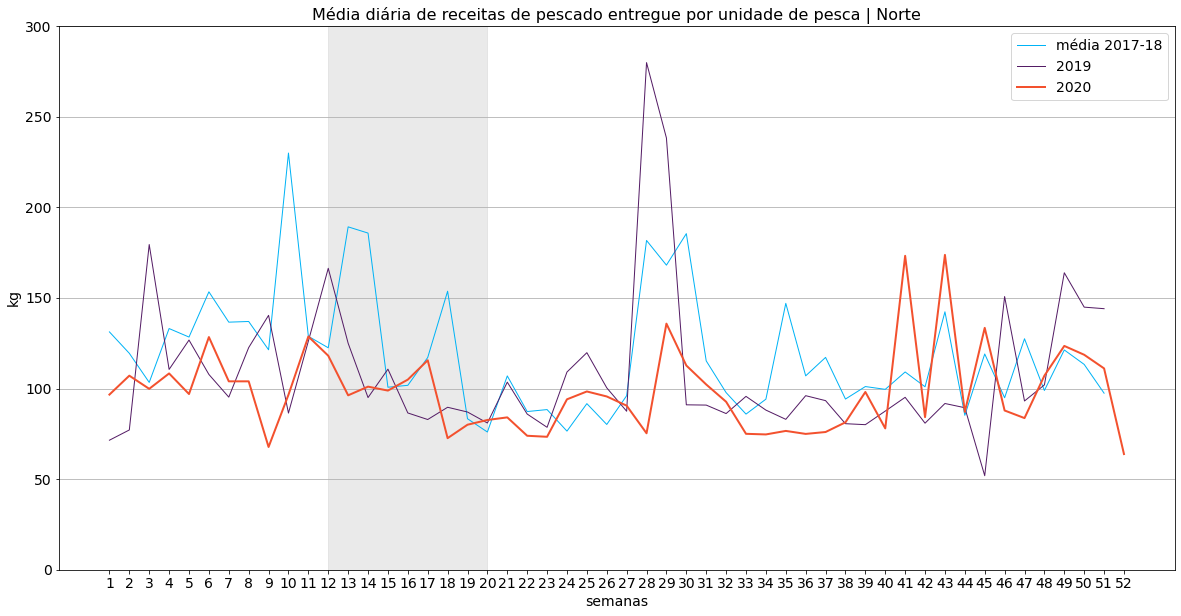

In [53]:
plot_weekly(df_final, "Norte", 'kg')

In [54]:
# Compare regions in terms of average volume per fishing unit in 2020

def plot_nuts2020(dataset, feature):
            
        figure, ax = plt.subplots(figsize=(20, 10))
        
        dataset = dataset.groupby(by = ['nuts', 'year_week']).agg({ 
                                                    'kg': 'mean',
                                                    'euros': 'mean',
                                                    'prméd': 'mean',
                                                    'StringencyIndex': 'mean',
                                                    'interp_stays': 'mean',
                                                    'interpolated_rest': 'mean'
                                                   }).reset_index()
        
        
        

        dataset_20 = dataset[(dataset['year_week'].astype(int) >= 202001)].reset_index()
    
        dataset_20_pivot = dataset_20.pivot(index = 'year_week', columns = 'nuts', values = feature).reset_index() 

        colors_list = ['#00b3f6', '#541c65', '#f3512e', '#085683', '#fcb0a4']
        
        colors_list = ['#541c65', '#007abf', '#99daff', '#f3512e', '#ffc1b8']
        
        #'#f9d979', '#00b3f6'
        
        markers_list = ['o', 's', 'v', 'd', 'X']
        
        i = 0
        
        for nut in ['Norte', 'Centro', 'AML', 'Alentejo', 'Algarve']:
            plt.plot(nut, data=dataset_20_pivot, color=colors_list[i], marker='.', linewidth=1.4)
            i += 1  
            
            
            #plt.plot('Centro', data=dataset_20_pivot, color='#541c65', linewidth=1)
            #plt.plot('AML', data=dataset_20_pivot, color='#f3512e', linewidth=1)
            #plt.plot(feature, data=dataset_20_pivot, color='#085683', label='Alentejo', linewidth=1)
            #plt.plot(feature, data=dataset_20_pivot, color='#ffc1b8', label='Algarve', linewidth=1)

        labels=[]
        for num in np.arange(1, 54):
            labels.append(num)
        
        x = np.arange(len(labels))
        
        ax.fill_between(x, 0, 1, where= (x >= 11) & (x < 20),
                color='#d6d6d6', alpha=0.5, transform=ax.get_xaxis_transform())
        
        plt.xticks(x, labels, fontsize=14)
        
        plt.ylabel(feature, fontsize = 14)
        plt.xlabel('semanas', fontsize = 14)
        
        plt.ylim(bottom=0, top = 300)
        
        if feature == 'StringencyIndex':
            plt.title(('Average weekly stringency index'), fontsize = 16)
        else:
            plt.title(('Média diária de volume de pescado (kg) vendido por unidade de pesca em 2020, por semana'), fontsize = 16)
    
        plt.yticks(fontsize=14) 
        plt.legend(fontsize = 14)#, bbox_to_anchor=(1.2, 1))
    
        plt.grid(axis='y')

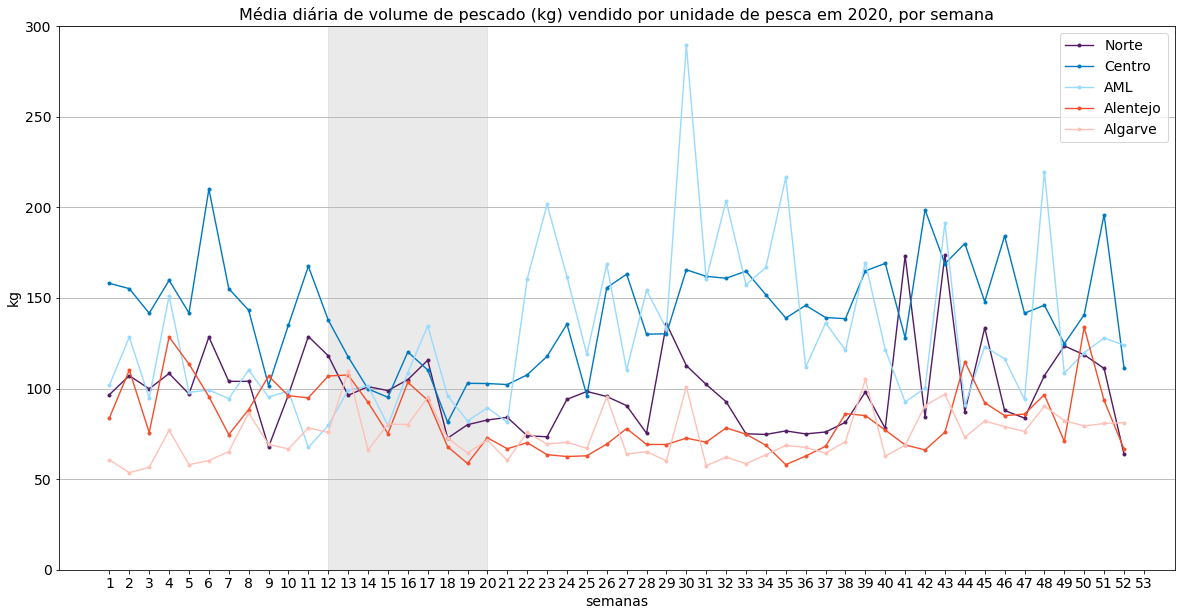

In [55]:
plot_nuts2020(df_final, 'kg')

## Average kgs delivered at Lotas and F/Lotas

In [56]:
comp_lota_type = df_final.groupby(['nuts', 'lota_flag']).agg({ 
                                                    'kg': 'mean',
                                                    'BarcoId': 'nunique'
                                                    #'euros': 'mean',
                                                    #'prméd': 'mean'
                                                   }).reset_index()

comp_lota_pivot = comp_lota_type.pivot(index = 'nuts', columns='lota_flag', values = ['kg', 'BarcoId']).reset_index()
comp_lota_pivot.columns = ['nuts', 'F/Lota_kg', 'Lota_kg', 'F/Lota_up', 'Lota_up']
comp_lota_pivot

,nuts,F/Lota_kg,Lota_kg,F/Lota_up,Lota_up
0,AML,214.42,106.30,244.00,768.00
1,Alentejo,20.02,82.47,27.00,139.00
2,Algarve,39.65,71.98,271.00,837.00
3,Centro,43.37,146.09,145.00,862.00
4,Norte,72.02,114.43,58.00,470.00


In [57]:
comp_lota_type_val = df_val_final.groupby(['nuts', 'lota_flag']).agg({ 
                                                    'kg': 'mean',
                                                    'BarcoId': 'nunique'
                                                    #'euros': 'sum',
                                                    #'prméd': 'mean'
                                                   }).reset_index()

comp_lota_val_pivot = comp_lota_type_val.pivot(index = 'nuts', columns='lota_flag', values = ['kg', 'BarcoId']).reset_index()
comp_lota_val_pivot.columns = ['nuts', 'F/Lota', 'Lota', 'F/Lota_up', 'Lota_up']
comp_lota_val_pivot

,nuts,F/Lota,Lota,F/Lota_up,Lota_up
0,AML,nan,35.92,nan,702.00
1,Alentejo,79.08,41.84,3.00,132.00
2,Algarve,13.78,46.09,193.00,810.00
3,Centro,15.65,50.81,106.00,721.00
4,Norte,25.07,31.67,48.00,351.00


In [58]:
comp_lota_type_econ = df_econ_final.groupby(['nuts', 'lota_flag']).agg({ 
                                                    'kg': 'mean',
                                                    'BarcoId': 'nunique'
                                                    #'euros': 'sum',
                                                    #'prméd': 'mean'
                                                   }).reset_index()

comp_lota_econ_pivot = comp_lota_type_econ.pivot(index = 'nuts', columns='lota_flag', values = ['kg', 'BarcoId']).reset_index()
comp_lota_econ_pivot.columns = ['nuts', 'F/Lota', 'Lota', 'F/Lota_up', 'Lota_up']
comp_lota_econ_pivot

,nuts,F/Lota,Lota,F/Lota_up,Lota_up
0,AML,300.53,81.21,198.00,719.00
1,Alentejo,71.69,47.11,3.00,134.00
2,Algarve,13.20,46.99,37.00,798.00
3,Centro,15.79,97.13,107.00,722.00
4,Norte,71.96,75.81,58.00,439.00


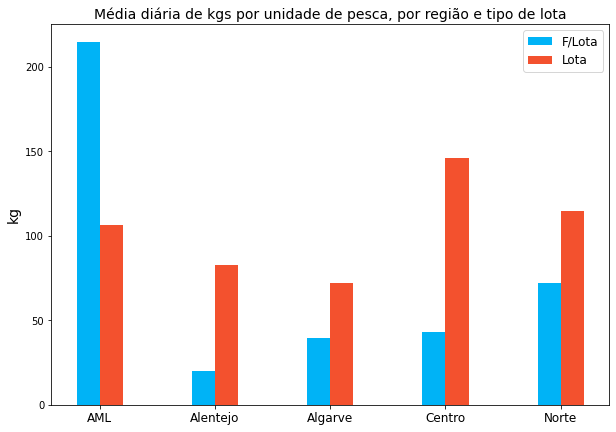

In [59]:
labels = list(comp_lota_pivot['nuts'])

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - (width/2), comp_lota_pivot['F/Lota_kg'], width, label='F/Lota', color = '#00b3f6')
rects2 = ax.bar(x + (width/2), comp_lota_pivot['Lota_kg'], width, label='Lota', color = '#f3512e')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('kg', fontsize=14)
ax.set_title('Média diária de kgs por unidade de pesca, por região e tipo de lota', fontsize=14)
plt.xticks(x, labels, fontsize=12)

plt.legend(fontsize = 12, bbox_to_anchor=(1, 1))

plt.xticks()

plt.show()

## Fishing composition by Lota type and region

In [60]:
df['lota_flag'] = df['Nome_Lota'].apply(lota_flag)

df_val['lota_flag'] = df_val['Nome_Lota'].apply(lota_flag)

df_econ_val['lota_flag'] = df_econ_val['Nome_Lota'].apply(lota_flag)

In [61]:
# number of units per species group

# replace "df" with the dataframe relative to each species group
# df = all species
# df_val = most valued species
# df_econ_val = species with highest economic weight

units = df.groupby(by = ['nuts', 'lota_flag']).agg({ 
                                                    'BarcoId': 'nunique'
                                                   }).reset_index()

units

,nuts,lota_flag,BarcoId
0,AML,0,246
1,AML,1,768
2,Alentejo,0,27
3,Alentejo,1,139
4,Algarve,0,272
5,Algarve,1,837
6,Centro,0,147
7,Centro,1,862
8,Norte,0,62
9,Norte,1,471


In [62]:
# species composition

# replace "df" with the dataframe relative to each species group
# df = all species
# df_val = most valued species
# df_econ_val = species with highest economic weight

species_composition = df.groupby(by = ['nuts', 'lota_flag', 'Nome_Espécie']).agg({ 
                                                    'kg': 'sum'
                                                   }).reset_index()
volume_per_lota = df.groupby(by = ['nuts', 'lota_flag']).agg({ 
                                                    'kg': 'sum'
                                                   }).reset_index()

volume_per_lota.columns = ['nuts', 'lota_flag', 'total_kgs']

species_composition = species_composition.merge(volume_per_lota, right_on = ['nuts', 'lota_flag'], left_on = ['nuts', 'lota_flag'])
species_composition['species_per'] = species_composition['kg']/species_composition['total_kgs']*100



In [63]:
species_composition_sel = species_composition.sort_values(by = ['nuts', 'lota_flag', 'species_per'], axis=0, ascending=False)
species_composition_sel[(species_composition_sel['nuts'] == 'Algarve') & (species_composition_sel['lota_flag'] == 0)].head(30)

,nuts,lota_flag,Nome_Espécie,kg,total_kgs,species_per
378,Algarve,0,Berbigão-vulgar,"524,249.00","1,038,633.00",50.47
387,Algarve,0,Cadelinhas,"214,845.90","1,038,633.00",20.69
369,Algarve,0,Amêijoa-boa,"79,351.30","1,038,633.00",7.64
423,Algarve,0,Perceve,"77,665.80","1,038,633.00",7.48
412,Algarve,0,Mexilhões,"34,158.30","1,038,633.00",3.29
409,Algarve,0,Longueirão-direito,"20,314.10","1,038,633.00",1.96
408,Algarve,0,Longueirão,"18,687.00","1,038,633.00",1.80
418,Algarve,0,Ostras,"10,976.50","1,038,633.00",1.06
419,Algarve,0,Ouriço-do-mar,"10,315.80","1,038,633.00",0.99
422,Algarve,0,Pepinos-do-mar,"6,221.00","1,038,633.00",0.60


In [64]:
species_composition_sel = species_composition_sel.groupby(['nuts', 'lota_flag']).head(5)
species_composition_sel[(species_composition_sel['nuts'] == 'Algarve')]# & (species_composition_sel['lota_flag'] == 1)].sort_values(['species_per'], ascending= False)

,nuts,lota_flag,Nome_Espécie,kg,total_kgs,species_per
579,Algarve,1,Polvo-vulgar,"4,264,319.30","13,182,843.30",32.35
490,Algarve,1,Cavala,"980,909.20","13,182,843.30",7.44
498,Algarve,1,Choco-vulgar,"939,350.90","13,182,843.30",7.13
507,Algarve,1,Dourada,"386,769.60","13,182,843.30",2.93
632,Algarve,1,Tamboril-preto,"378,889.70","13,182,843.30",2.87
378,Algarve,0,Berbigão-vulgar,"524,249.00","1,038,633.00",50.47
387,Algarve,0,Cadelinhas,"214,845.90","1,038,633.00",20.69
369,Algarve,0,Amêijoa-boa,"79,351.30","1,038,633.00",7.64
423,Algarve,0,Perceve,"77,665.80","1,038,633.00",7.48
412,Algarve,0,Mexilhões,"34,158.30","1,038,633.00",3.29


['Polvo-vulgar', 'Congro', 'Abrotea-da-costa', 'Raia-lenga', 'Raia-manchada', 'Outros']
[34.60863983703811, 9.01790799151417, 4.246902829464355, 3.4493298800422636, 2.955207044727571, 45.72201241721353]


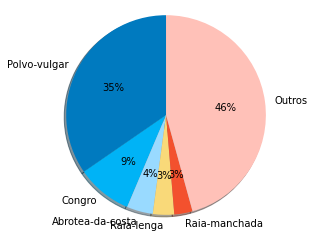

In [65]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(species_composition_sel[(species_composition_sel['nuts'] == 'Alentejo') & 
                                (species_composition_sel['lota_flag'] == 1)]['Nome_Espécie'].unique())
labels.append('Outros')
sizes = list(species_composition_sel[(species_composition_sel['nuts'] == 'Alentejo') & 
                                 (species_composition_sel['lota_flag'] == 1)]['species_per'].unique())



#labels = ['Polvo-vulgar', 'Sargo-legitimo', 'Robalo-legitimo', 'Outros']
#sizes = [89.87021467635296, 4.897559382907518, 4.252714064158028]

total = 0
for val in sizes:
    total = total + val
    
others_val = 100 - total  
sizes.append(others_val)

print(labels)
print(sizes)

fig1, ax1 = plt.subplots(figsize=(4,4))


ax1.pie(sizes, labels=labels, colors = ['#007abf', '#00b3f6', '#99daff','#f9d979', '#f3512e', '#ffc1b8'],
        shadow=True, startangle=90, autopct='%1.0f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# REGRESSION ANALYSIS

## GET LISTS WITH DIFFERENT GROUPS OF LOTAS

In [66]:
# List with all ports name

all_lotas = list(df_final[df_final['lota_flag']==1]['Nome_Lota'].unique())
all_lota_flota = list(df_final['Nome_Lota'].unique())
print(all_lotas)

['Costa da Caparica', 'Sesimbra', 'Setúbal', 'Sines', 'V.N.Milfontes', 'Albufeira', 'Lagos', 'Olhão', 'Portimão', 'Quarteira', 'Sagres', 'V.R.S. António', 'Aveiro', 'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 'Matosinhos', 'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo', 'Vila do Conde']


In [67]:
# List with ports name by nuts

algarve = list(df_agg[df_agg['nuts'] == 'Algarve']['Nome_Lota'].unique())
aml = list(df_agg[df_agg['nuts'] == 'AML']['Nome_Lota'].unique())
norte = list(df_agg[df_agg['nuts'] == 'Norte']['Nome_Lota'].unique())
centro = list(df_agg[df_agg['nuts'] == 'Centro']['Nome_Lota'].unique())
alentejo = list(df_agg[df_agg['nuts'] == 'Alentejo']['Nome_Lota'].unique())

In [68]:
# List only with Lotas names (not F/Lotas), per region

algarve_lota = list(df_agg[(df_agg['nuts'] == 'Algarve') & (~df_agg['Nome_Lota'].str.contains('/'))]['Nome_Lota'].unique())
aml_lota = list(df_agg[(df_agg['nuts'] == 'AML') & (~df_agg['Nome_Lota'].str.contains('/'))]['Nome_Lota'].unique())
norte_lota = list(df_agg[(df_agg['nuts'] == 'Norte') & (~df_agg['Nome_Lota'].str.contains('/'))]['Nome_Lota'].unique())
centro_lota = list(df_agg[(df_agg['nuts'] == 'Centro') & (~df_agg['Nome_Lota'].str.contains('/'))]['Nome_Lota'].unique())
alentejo_lota = list(df_agg[(df_agg['nuts'] == 'Alentejo') & (~df_agg['Nome_Lota'].str.contains('/'))]['Nome_Lota'].unique())

## FIXED EFFECTS REGRESSION

In [69]:
# data selection and transformation for regression

def select_for_regression(df, lotas):

    df_sel = df[df['Nome_Lota'].isin(lotas)].copy()

    print("First week in dataset: ", df_sel.year_week.min())
    print("Last week in dataset: ",df_sel.year_week.max())
    print("Lotas in dataset: ", df_sel.Nome_Lota.unique())
    
    df_sel[['month']] = df_sel[['month']].astype(str)
    df_dum = pd.get_dummies(df_sel[['month']])

    df_sel = df_sel.join(df_dum).copy()
    
    df_sel = df_sel.dropna()
    
    df_sel['year_week'] = df_sel['year_week'].astype(int)

    df_sel = df_sel.set_index(['BarcoId', 'year_week'])
    
    print(df_sel.shape)
    
    return df_sel

In [70]:
# Wrapper function to run regression

def run_regression(species, region, treatment, port_type, controls, macro):
    if species == 'val':
        dataset = select_for_regression(df_val_final, region)
     
    elif species == 'econ':
        dataset = select_for_regression(df_econ_final, region)
    
    elif species == 'all':
        dataset = select_for_regression(df_final, region)
    
    dataset = dataset.dropna()
    
    variables = []
    
    
    if treatment == 'stringency':
        variables.append('StringencyIndex')
        
            
    elif treatment == 'restaurant':
        variables.append('treatm_rest_closed')
    
    if controls == True:
        
        if treatment == 'stringency':
            if (species == 'val') & ((region == aml) | (region == alentejo)):
                pass
            
            elif port_type == 'lota':
                    variables.append('flota_flag')
                    variables.append('flota_x_stringency')

            elif port_type == 'flota':
                    variables.append('lota_flag')
                    variables.append('lota_x_stringency')
                    
            
        elif treatment == 'restaurant':
            if (species == 'val') & ((region == aml) | (region == alentejo)):
                pass

            elif port_type == 'lota':
                variables.append('flota_flag')
                variables.append('flota_treat_rest')
            elif port_type == 'flota':
                variables.append('lota_flag')
                variables.append('lota_treat_rest')    
        
        variables.extend(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
                        'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                          'swh', 'sst', 'mwd', 'mwp', 'wind', 'dwi'])    
        
        if macro == True:
            variables.append('lagged_prméd')
    
            if treatment == 'stringency':
                if region != aml:
                    variables.append('interp_stays')

            if treatment == 'restaurant':
                variables.extend(['interp_stays', 'interpolated_rest'])
        
    
    print(variables)
    
    mod = PanelOLS(dataset.kg, sm.add_constant(dataset[variables]), entity_effects = True)
    re_res = mod.fit(cov_type='clustered', clusters=dataset[['Nome_Lota']])
    return re_res.summary
        

In [86]:
run_regression(species = 'econ', region = algarve, 
               treatment = 'stringency', 
               port_type = 'flota',
               controls = True, macro = True)

First week in dataset:  201702
Last week in dataset:  202053
Lotas in dataset:  ['Albufeira' 'Lagos' 'Lagos/F Lota' 'Olhão' 'Portimão' 'Quarteira'
 'Sagres' 'Sagres/F Lota' 'V.R.S. António']
(67438, 42)
['StringencyIndex', 'lota_flag', 'lota_x_stringency', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'swh', 'sst', 'mwd', 'mwp', 'wind', 'dwi', 'lagged_prméd', 'interp_stays']


Dep. Variable:,kg,R-squared:,0.0602
Estimator:,PanelOLS,R-squared (Between):,-0.0233
No. Observations:,67438,R-squared (Within):,0.0602
Date:,"Mon, May 17 2021",R-squared (Overall):,0.0251
Time:,20:50:06,Log-likelihood,-3.517e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,193.86
Entities:,811,P-value,0.0000
Avg Obs:,83.154,Distribution:,"F(22,66605)"
Min Obs:,1.0000,,
Max Obs:,259.00,F-statistic (robust):,5.668e+14


### Plot the treatment effects and standard errors

In [72]:
nuts_list = ['Norte-Lota', 'Norte-F/Lota', 
             'Centro-Lota', 'Centro-F/Lota',
             'AML-Lota', 'AML-F/Lota', 
             'Alentejo-Lota', 'Alentejo-F/Lota', 
             'Algarve-Lota', 'Algarve-F/Lota']

## Effects and errors for all species
te_rest_list = [-14.43, 13.10, 
                -18.12, -8.24, 
                11.50, 78.74, 
                -5.69, -11.36, 
                9.62, 4.77]
errors_rest_list = [7.18, 5.53, 
                    16.17, 13.96, 
                    11.59, 24.10, 
                    3.42, 0.84, 
                    4.49, 6.62]

te_stringency_list = [-0.25, 0.06, 
                      -0.04, -0.13, 
                      0.05, 1.54, 
                      0.03, -0.03, 
                      0.32, 0.27]
errors_stringency_list = [0.09, 0.11, 
                          0.10, 0.16, 
                          0.17, 0.64, 
                          0.02, 0.01, 
                          0.06, 0.06]


## Effects and errors for the most valued species
te_val_rest_list = [-8.10, -7.17, 
                    -5.92, -7.84, 
                    -3.19, 0, 
                    4.99, 0, 
                    10.61, 0.44]
errors_val_rest_list = [1.74, 3.35, 
                        9.50, 5.74, 
                        1.73, 0, 
                        0.32, 0, 
                        2.43, 1.82]


te_val_stringency_list = [-0.25, -0.20, 
                          -0.13, -0.12, 
                          -0.002, 0, 
                          0.18, 0, 
                          0.33, 0.25]
errors_val_stringency_list = [0.07, 0.05, 
                              0.14, 0.13, 
                              0.02, 0, 
                              0.02, 0, 
                              0.05, 0.06]


## Effects and errors for species with highest economic weight
te_econ_rest_list = [-5.43, 33.93, 
                    -7.42, -4.70, 
                    11.13, 189.16, 
                    -1.25, 0, 
                    8.41, 0]
errors_econ_rest_list = [11.90, 7.80, 
                        10.18, 9.12, 
                        11.13, 54.77, 
                        2.13, 0, 
                        2.35, 0]


te_econ_stringency_list = [-0.08, 0.28, 
                          -0.03, -0.06, 
                          0.03, 2.83, 
                          0.04, 0,
                          0.34, 0]
errors_econ_stringency_list = [0.15, 0.19, 
                              0.13, 0.16, 
                              0.14, 0.14, 
                              0.01, 0, 
                              0.05, 0]

In [73]:
# Aggregate effects and errors into a single dataframe

treatment_effects_df = pd.DataFrame(list(zip(nuts_list, 
                                             te_rest_list, errors_rest_list,
                                             te_stringency_list, errors_stringency_list,
                                             te_val_rest_list, errors_val_rest_list,
                                             te_val_stringency_list, errors_val_stringency_list,
                                             te_econ_rest_list, errors_econ_rest_list,
                                             te_econ_stringency_list, errors_econ_stringency_list
                                            )),
               columns =['port', 
                         'te_rest', 'errors_rest', 'te_stringency', 'errors_stringency', 
                         'te_val_rest', 'errors_val_rest', 'te_val_stringency', 'errors_val_stringency',
                         'te_econ_rest', 'errors_econ_rest', 'te_econ_stringency', 'errors_econ_stringency' 
                        ])
treatment_effects_df

,port,te_rest,errors_rest,te_stringency,errors_stringency,te_val_rest,errors_val_rest,te_val_stringency,errors_val_stringency,te_econ_rest,errors_econ_rest,te_econ_stringency,errors_econ_stringency
0,Norte-Lota,-14.43,7.18,-0.25,0.09,-8.10,1.74,-0.25,0.07,-5.43,11.90,-0.08,0.15
1,Norte-F/Lota,13.10,5.53,0.06,0.11,-7.17,3.35,-0.20,0.05,33.93,7.80,0.28,0.19
2,Centro-Lota,-18.12,16.17,-0.04,0.10,-5.92,9.50,-0.13,0.14,-7.42,10.18,-0.03,0.13
3,Centro-F/Lota,-8.24,13.96,-0.13,0.16,-7.84,5.74,-0.12,0.13,-4.70,9.12,-0.06,0.16
4,AML-Lota,11.50,11.59,0.05,0.17,-3.19,1.73,-0.00,0.02,11.13,11.13,0.03,0.14
5,AML-F/Lota,78.74,24.10,1.54,0.64,0.00,0.00,0.00,0.00,189.16,54.77,2.83,0.14
6,Alentejo-Lota,-5.69,3.42,0.03,0.02,4.99,0.32,0.18,0.02,-1.25,2.13,0.04,0.01
7,Alentejo-F/Lota,-11.36,0.84,-0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,Algarve-Lota,9.62,4.49,0.32,0.06,10.61,2.43,0.33,0.05,8.41,2.35,0.34,0.05
9,Algarve-F/Lota,4.77,6.62,0.27,0.06,0.44,1.82,0.25,0.06,0.00,0.00,0.00,0.00


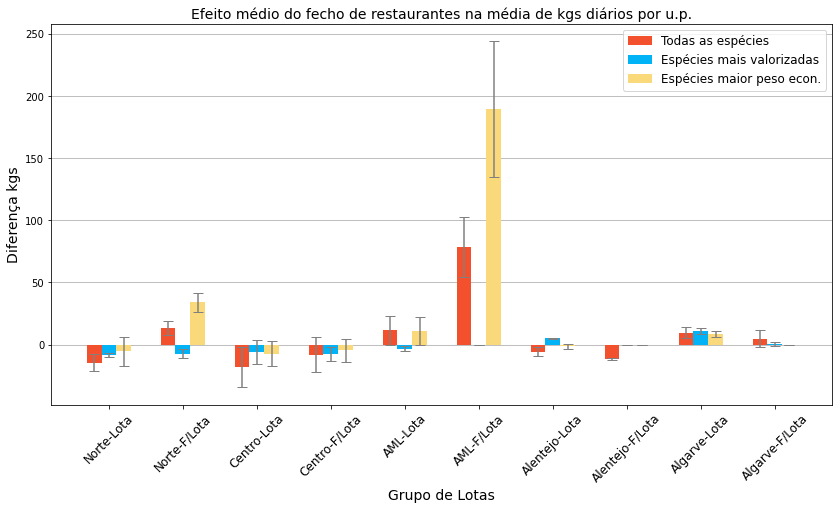

In [74]:
# Plot treatment effects for restaurant closure

labels = treatment_effects_df['port']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7))

ax.grid(axis='y', zorder=0)

rects1 = ax.bar(x - (width), treatment_effects_df['te_rest'], width=width, label='Todas as espécies', color = '#f3512e', yerr=treatment_effects_df['errors_rest'], align='center', ecolor='grey', capsize=5, zorder=3)
rects2 = ax.bar(x, treatment_effects_df['te_val_rest'], width=width, label='Espécies mais valorizadas', color = '#00b3f6', yerr=treatment_effects_df['errors_val_rest'], align='center', ecolor='grey', capsize=5, zorder=3)
rects3 = ax.bar(x + (width), treatment_effects_df['te_econ_rest'], width=width, label='Espécies maior peso econ.', color = '#f9d979', yerr=treatment_effects_df['errors_econ_rest'], align='center', ecolor='grey', capsize=5, zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Grupo de Lotas', fontsize=14)
ax.set_ylabel('Diferença kgs', fontsize=14)
ax.set_title('Efeito médio do fecho de restaurantes na média de kgs diários por u.p.', fontsize=14)
plt.xticks(x, labels, rotation=45, fontsize=12)

#ax.legend()

#ax.axhline(linewidth=1, color='black')

plt.legend(fontsize = 12, bbox_to_anchor=(1, 1))

plt.xticks()


plt.show()

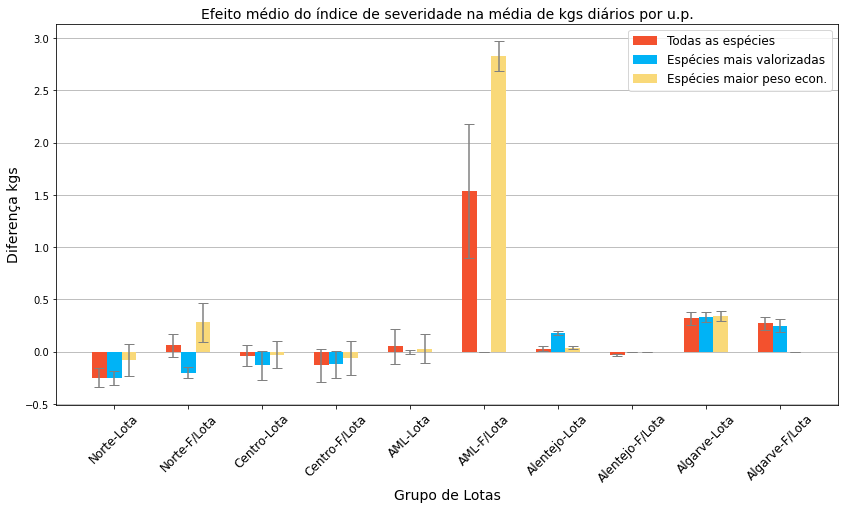

In [75]:
# Plot treatment effects for restaurant closure

labels = treatment_effects_df['port']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7))

ax.grid(axis='y', zorder=0)

rects1 = ax.bar(x - (width), treatment_effects_df['te_stringency'], width=width, label='Todas as espécies', color = '#f3512e', yerr=treatment_effects_df['errors_stringency'], align='center', ecolor='grey', capsize=5, zorder=3)
rects2 = ax.bar(x, treatment_effects_df['te_val_stringency'], width=width, label='Espécies mais valorizadas', color = '#00b3f6', yerr=treatment_effects_df['errors_val_stringency'], align='center', ecolor='grey', capsize=5, zorder=3)
rects3 = ax.bar(x + (width), treatment_effects_df['te_econ_stringency'], width=width, label='Espécies maior peso econ.', color = '#f9d979', yerr=treatment_effects_df['errors_econ_stringency'], align='center', ecolor='grey', capsize=5, zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Grupo de Lotas', fontsize=14)
ax.set_ylabel('Diferença kgs', fontsize=14)
ax.set_title('Efeito médio do índice de severidade na média de kgs diários por u.p.', fontsize=14)
plt.xticks(x, labels, rotation=45, fontsize=12)

#ax.legend()

#ax.axhline(linewidth=1, color='black')

plt.legend(fontsize = 12, bbox_to_anchor=(1, 1))

plt.xticks()


plt.show()

In [76]:
avg_stringency = df_final[df_final['treatm_rest_closed'] == 1][['year_week', 'StringencyIndex']].drop_duplicates()
avg_stringency['StringencyIndex'].mean()

79.35142857142857